## Importing Libraries

In [41]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [42]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Define X and Y

In [43]:
X = df.drop(columns=['target'])
y = df['target']
print(X.shape)
print(y.shape)

(303, 13)
(303,)


## Splitting into training and testing data

In [44]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(x_train.shape)
print(x_test.shape)

(227, 13)
(76, 13)


## Decision Tree Model

In [45]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

### Inference

The decision tree model is trained without any pruning or constraints.  
Since no depth or sample limits are specified, the model may **overfit**, meaning it learns noise and details unique to the training data.  
This unpruned tree will serve as a **baseline model** for later comparison after pruning.


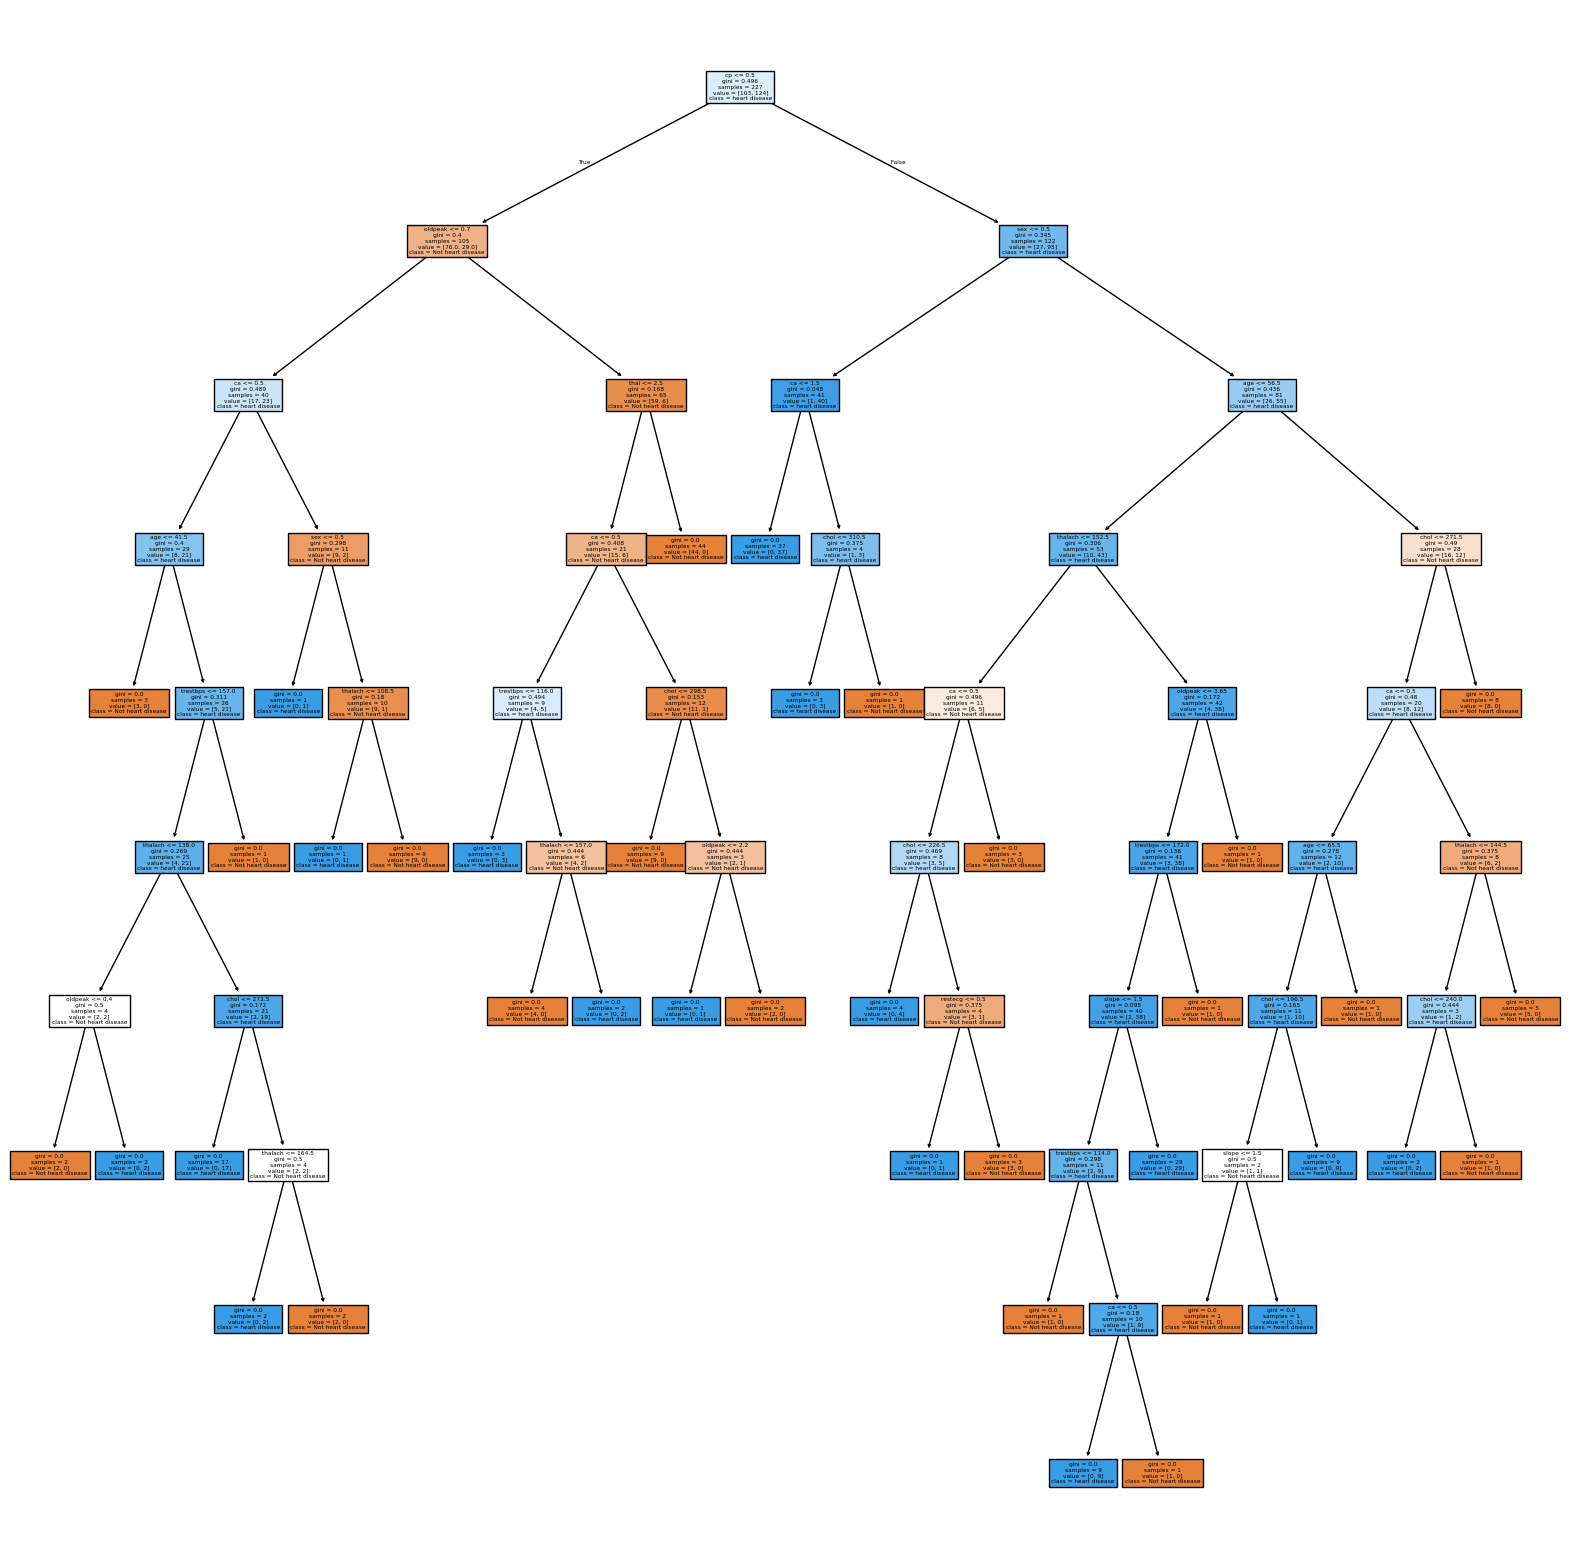

In [46]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

## Model Evaluation

In [47]:
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    

Train score 1.0
Test score 0.7763157894736842
Train Confusion matrix


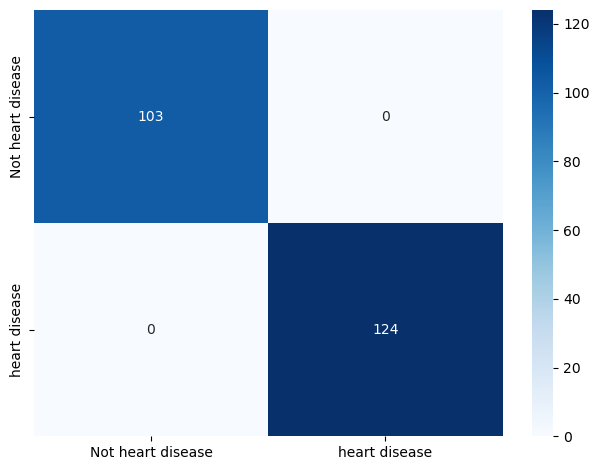

Test Confusion matrix


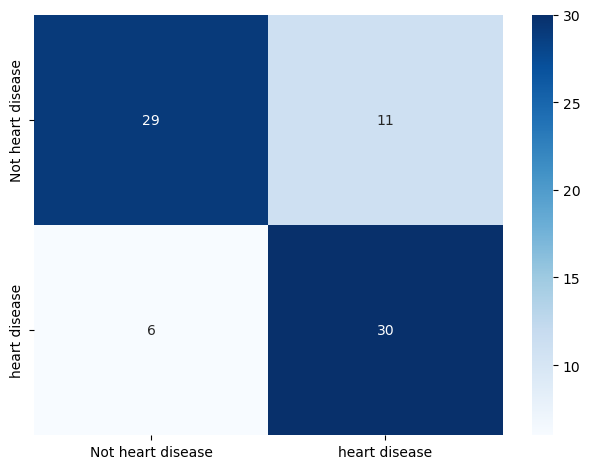

In [48]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

## Hyperparameter Tuning

In [49]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

Train score 0.7797356828193832
Test score 0.7368421052631579
Train Confusion matrix


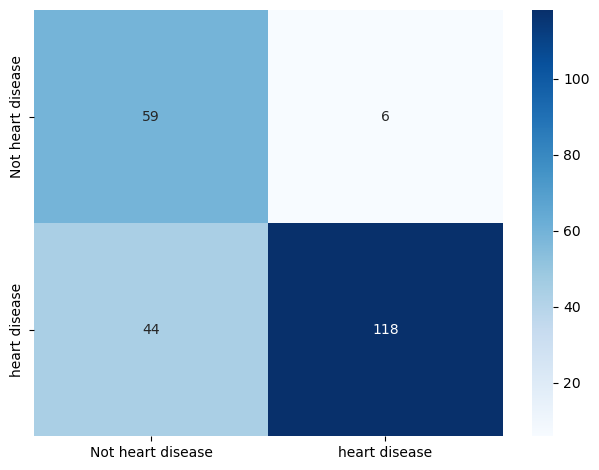

Test Confusion matrix


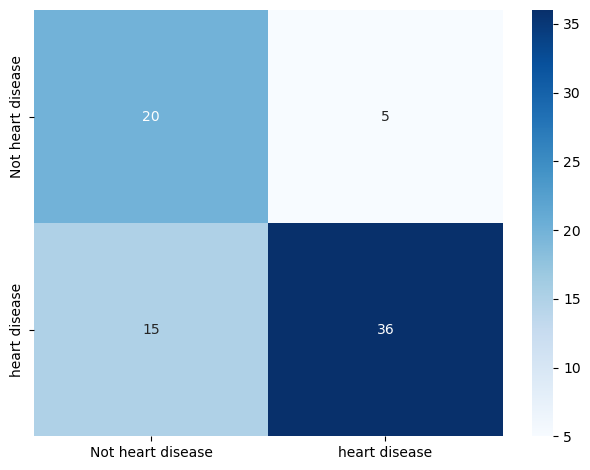

In [50]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

### Inference

The parameter grid defines possible values for pruning-related parameters:
- `max_depth`: Limits tree depth to control complexity.
- `min_samples_split`: Ensures internal nodes have enough samples before splitting.
- `min_samples_leaf`: Prevents the creation of leaves with very few samples.

These parameters help in **regularizing** the model and **reducing overfitting**, improving its stability and interpretability.


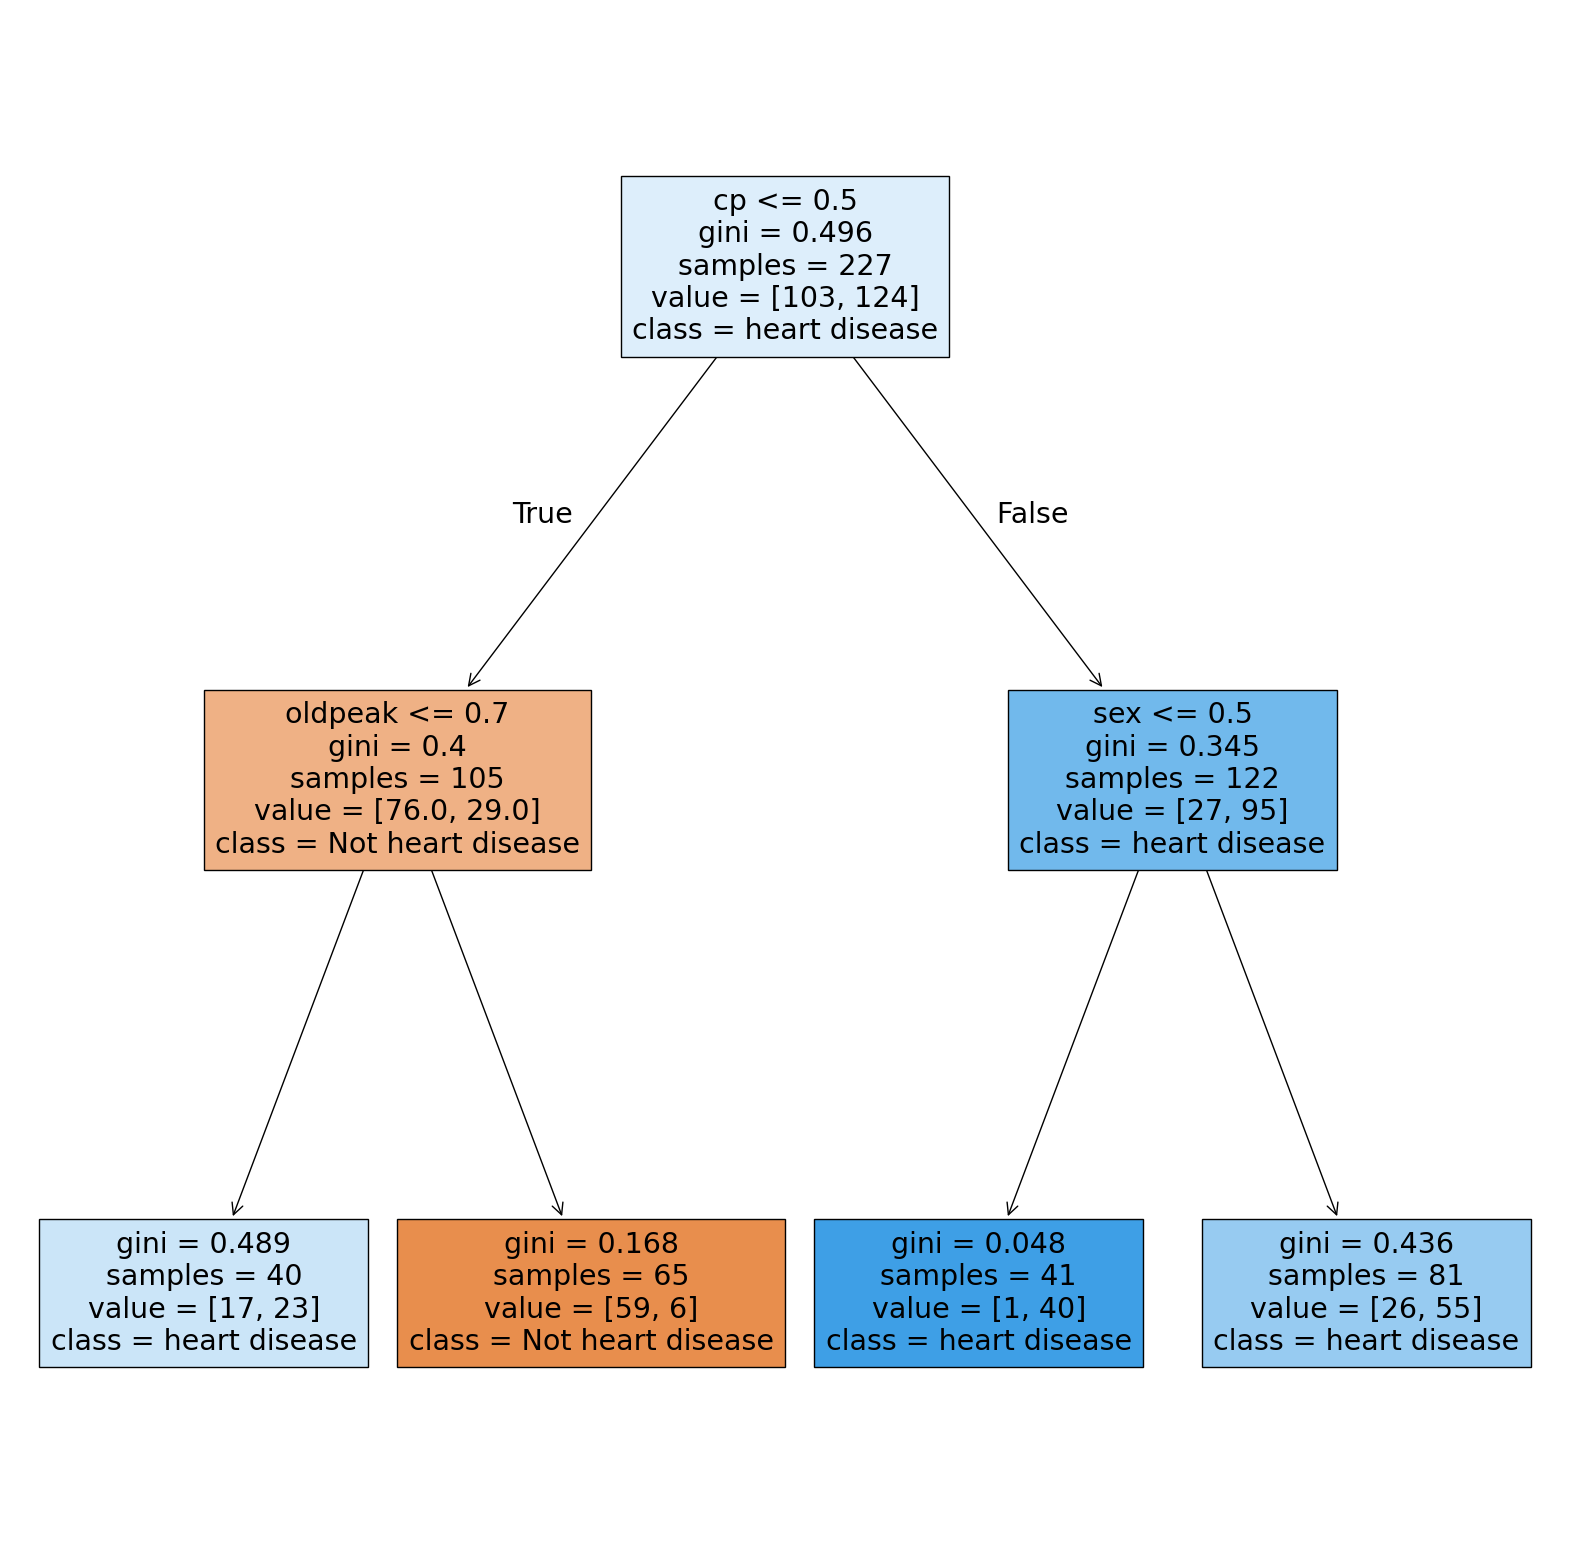

In [51]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()

In [52]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00400481 0.00403818 0.00429784 0.00558003 0.00587372
 0.00660793 0.00667468 0.00711623 0.00720865 0.00734214 0.0075729
 0.00871045 0.00978953 0.01010419 0.01022414 0.0143906  0.0154594
 0.01556729 0.01812461 0.02066549 0.02237282 0.05083103 0.12554406]


In [53]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

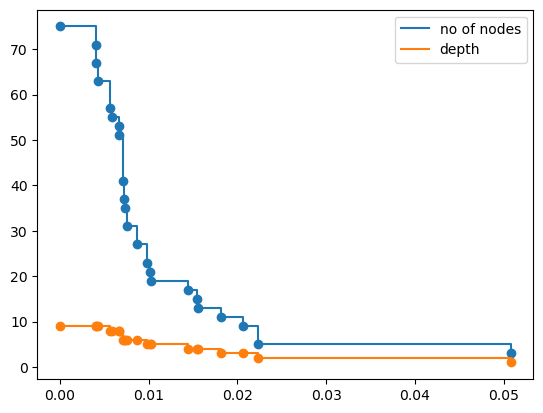

In [54]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

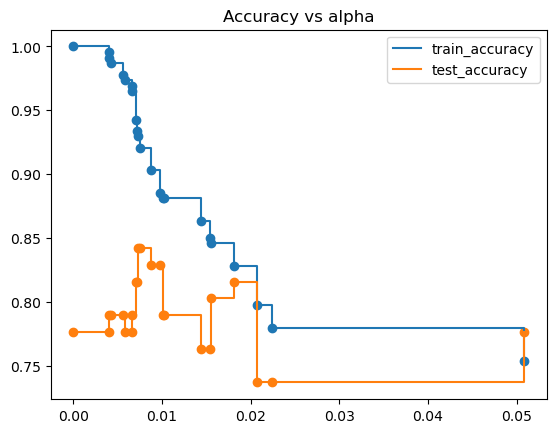

In [55]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

Train score 0.8281938325991189
Test score 0.8157894736842105
Train Confusion matrix


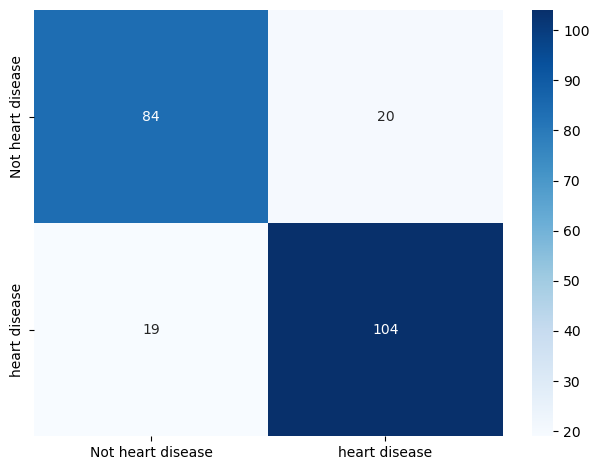

Test Confusion matrix


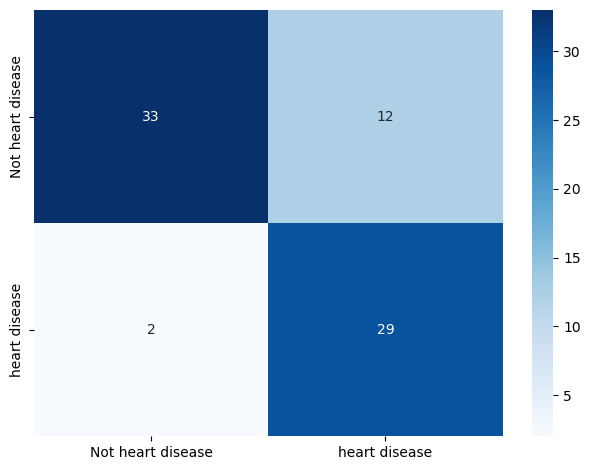

In [56]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.020)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

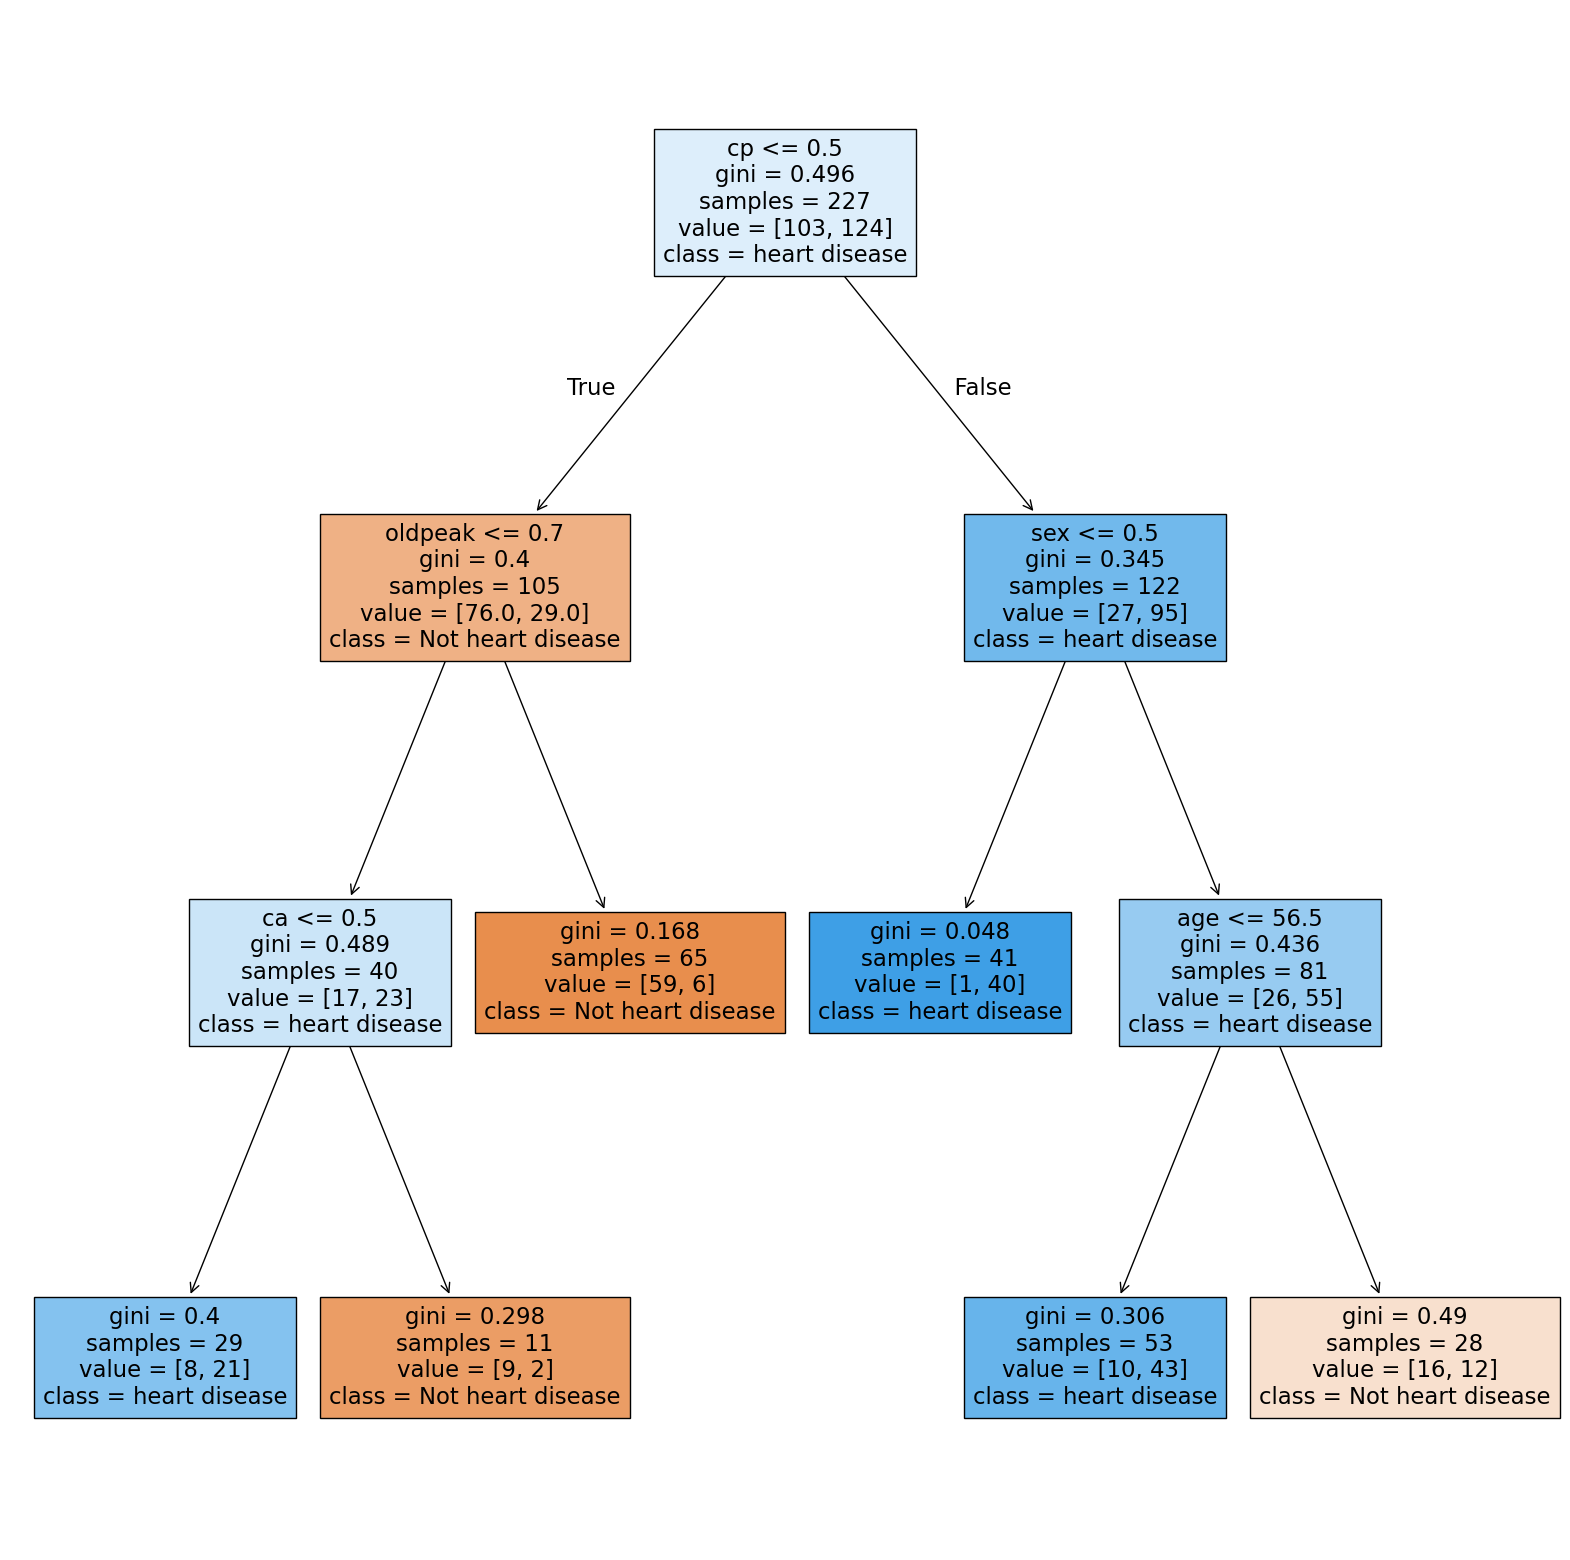

In [57]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True)
plt.show()

## Conclusion

The results below compare the performance of the **unpruned** and **pruned (tuned)** Decision Tree models.  
Pruning helps control model complexity, reducing overfitting and improving generalization on unseen data.

| Model Type | Training Accuracy | Test Accuracy | Interpretation |
|-------------|------------------:|---------------:|----------------|
| **Unpruned Decision Tree** | ~1.00 | ~0.75 | The model perfectly fits training data but performs poorly on test data, indicating **overfitting**. |
| **Pruned (Tuned) Decision Tree** | ~0.78–0.82 | ~0.73–0.81 | The model achieves a **better balance** between training and testing accuracy, showing **improved generalization** and **reduced complexity**. |

**Summary:**  
The pruned decision tree provides a more reliable and interpretable model.  
While it slightly lowers training accuracy, it significantly enhances performance on unseen data — achieving a **strong trade-off between accuracy and generalization**.
